# Modèles dynamiques pour la gestion énergétique des bâtiments - Groupe SEM 7

Ce notebook présente une simulation thermique dynamique d’un bâtiment simplifié, modélisé avec 5 murs identiques à deux couches, un mur vitré, une infiltration d’air et un contrôle de température. 

Le code se trouve en annexe à la fin du document, cependant pour des soucis inconnus ( apparemment, Binder serait plus strict qu'Anaconda ), il ne fonctionne pas sur notre notebook dynamique. Veuillez l'installer en accedant à notre github ainsi qu'en mettant les 2 fichiers "dm4bem.py3 et "FRA_Lyon.074810_IWEC.epw" dans le même répertoire.

L'objectif est de modéliser thermiquement ce bâtiment à l'aide d'équations différentielles algébriques.


## Modèle et régime permanent

Nous décidons de modéliser notre bâtiment comme ci-dessous, avec 2 pièces différentes séparées par une porte en bois de chêne. La grande salle possède un mur vitré et fait 20m² tandis que la petite salle fait elle 6.25m². Le HVAC intéragit avec les deux pièces.

<p align="center">
    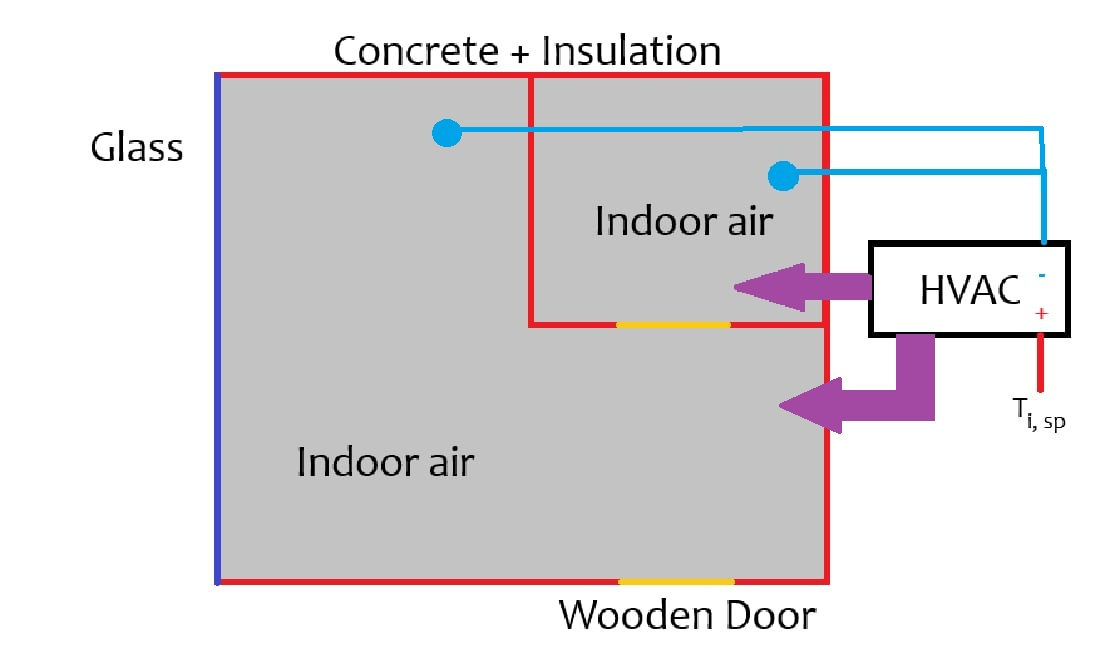
</p>

Les surfaces extérieures de la maison sont à la température extérieure T0.
La porte est en chêne car elle est bien isolée. Les fenêtres sont en verre à double vitrage. Les murs de la grande pièce sont en béton et l'isolation est en laine de verre.

### Conductance thermiques

#### Conduction
$C = \frac{λS}{e}$ (W.K-1)
- λ conductivité thermique du matériau (W/m.K)
- S surface de la section transversale (m2)
- e largeur (m)

#### Convection  
$G_{cv}=hS$
- S la surface de convection (m2)
- h le coefficient de transfert de chaleur par convection (W/m2.K)

#### Rayonnement 
$$
\left\{
\begin{aligned}
G &= \frac{1}{\frac{1}{G_1} + \frac{1}{G_{1,2}} + \frac{1}{G_2}} \\
G_1 &= 4 \sigma T^3 \cdot \frac{\varepsilon_1}{1 - \varepsilon_1} \cdot S_1 \\
G_{1,2} &= 4 \sigma T^3 F_{1,2} S_1 = 4 \sigma T^3 F_{2,1} S_2 \\
G_2 &= 4 \sigma T^3 \cdot \frac{\varepsilon_2}{1 - \varepsilon_2} \cdot S_2
\end{aligned}
\right.
$$


- $\varepsilon$ : l’émissivité  
- $\sigma$ : la constante de Boltzmann  
- $S_i$ : la surface rayonnante de la surface *i* (m²)  
- $T$ : la température de surface (K)

Pour l’advection :

$$
G_{adv} = \dot{m} \cdot c_p
$$

- $\dot{m}$ : le débit massique du fluide (kg/s)  
- $c_p$ : la capacité calorifique massique du fluide (J/kg·K)

### Capacité thermique des parois

$$
C_w = m_w c_w = \rho_w c_w w_w S_w
$$

- $m_w$ : masse du matériau constituant la paroi (en kg)  
- $c_w$ : capacité thermique massique du matériau (en J/(kg·K))  
- $\rho_w$ : masse volumique du matériau (kg/m³)  
- $w_w$ : épaisseur de la paroi (m)  
- $S_w$ : surface de la paroi (m²)


**Béton** : $C_{wc} = 57\,500 \ \text{J·K}^{-1}$

**Isolant** : $C_{wi} = 550 \ \text{J·K}^{-1}$

**Verre** : $C_g = 30\,250\,000 \ \text{J·K}^{-1}$

**Chêne** : $C_o = 19\,572{,}5 \ \text{J·K}^{-1}$

## Schéma électrique

Nous pouvons créer une modélisation électrique de ce bâtiment comme ci-dessous :

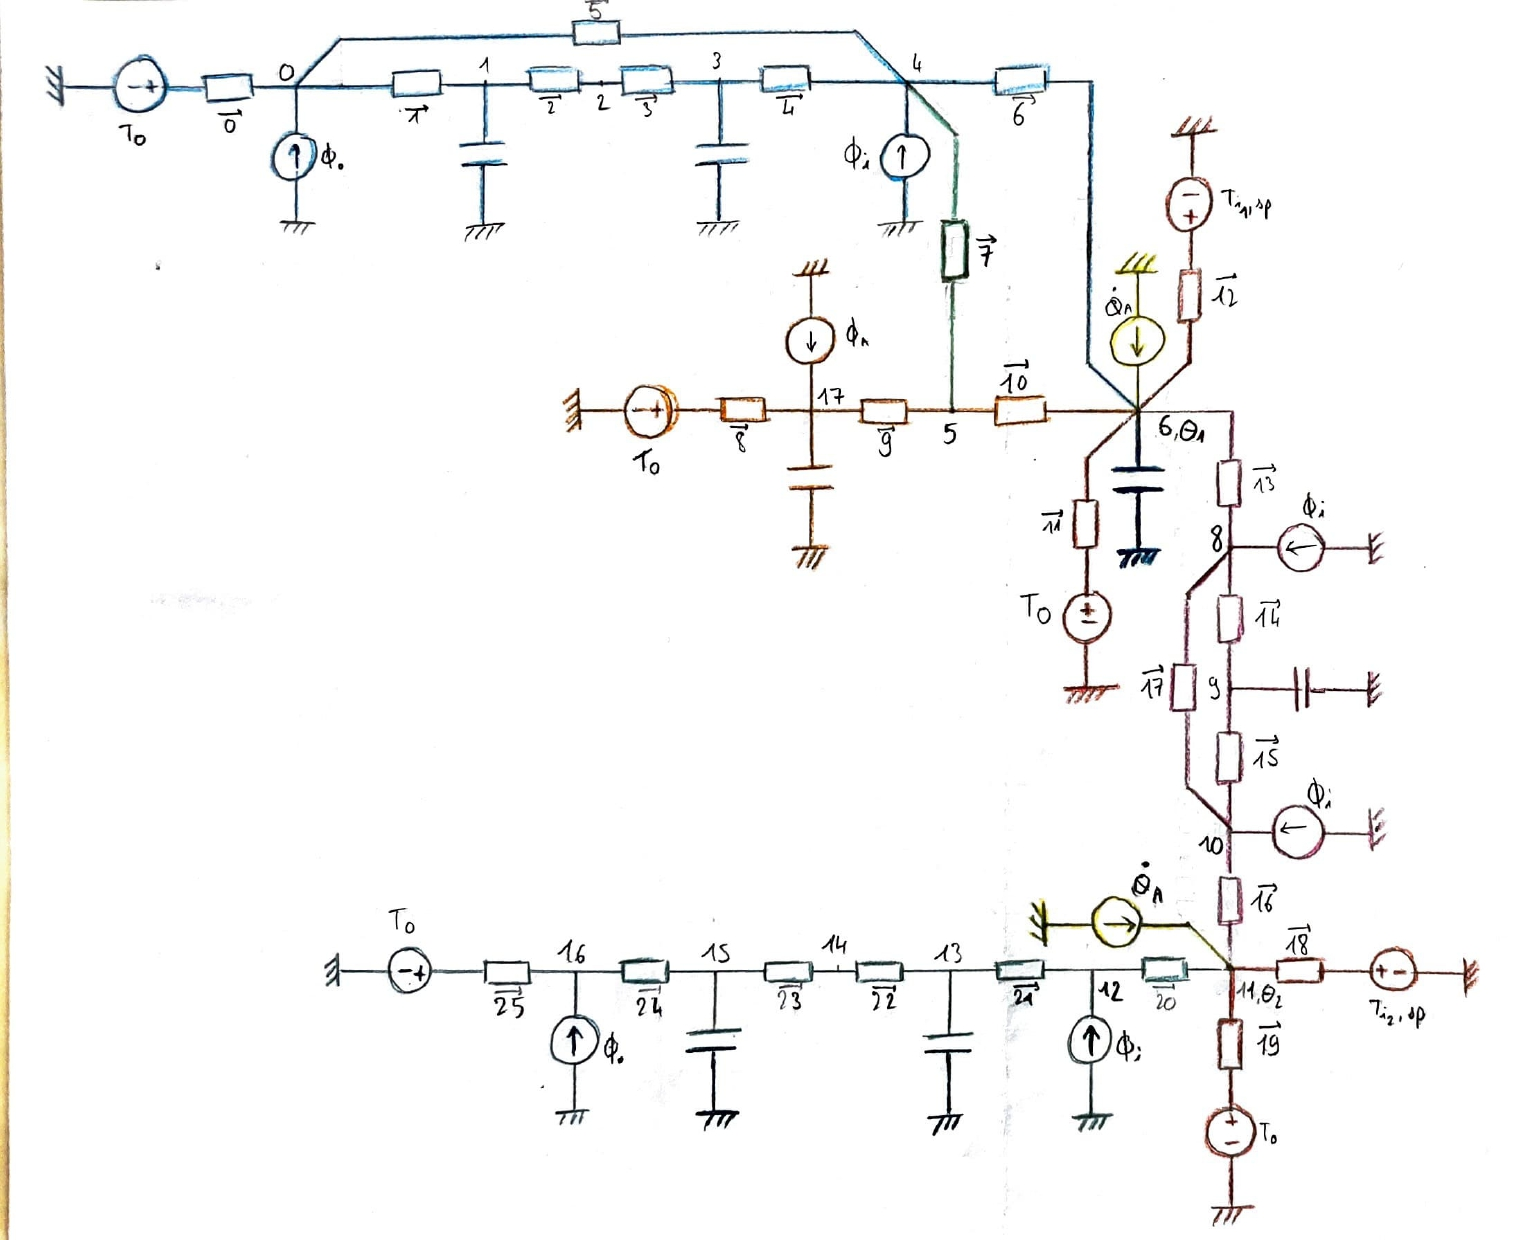


### Légende

- Bleu = Mur isolé entre pièce principale et extérieur    
- Orange = Mur vitré   
- Jaune = Electroménager dans la pièce principale 
- Rouge = Ventilation + HVAC 
- Mauve = Mur intérieur
- Vert = Mur extérieur de la pièce secondaire

À partir de ce schéma, nous calculons les différentes matrices : 
    -Matrice d'incidence A
    -Matrice de conductance G
    -Matrice de capacité C


### Matrice d'incidence $A$

Grâce au circuit thermique avec nœuds et débits, on détermine la matrice d’incidence $A$. Pour remplir cette matrice d’incidence, on associe chaque branche à une ligne et chaque nœud à une colonne. On place +1 à la colonne du nœud d’arrivée, –1 à celle du nœud de départ, et 0 ailleurs, en respectant l’orientation choisie pour chaque branche.



### Matrice de conductance $G$

La matrice G est une matrice diagonale qui regroupe les conductances thermiques des différentes branches du circuit thermique. Chaque terme correspond à une conductance liée à un élément du bâtiment (mur, porte, vitrage, etc.). On l’a remplie en affectant à chaque branche sa conductance équivalente, et en tenant compte des symétries quand un même matériau apparaît deux fois (par exemple pour les couches intérieure et extérieure).

$$
G = \begin{bmatrix}
R_0^{-1} & & \\
& R_1^{-1} & \\
& & \ddots \\
& & & R_{n_q - 1}^{-1}
\end{bmatrix}
$$

où $n_q$ est le nombre de branches de débit.


### Matrice de capacité $C$

La matrice C est une matrice diagonale qui contient les capacités thermiques associées aux nœuds du modèle. Elle est remplie à partir des matériaux présents dans les parois (couches internes, couches externes, etc.). Si neglect_air_glass==True, on ignore les capacités thermiques de l’air et du vitrage pour simplifier le modèle. Sinon, on les ajoutedans la matrice. Chaque terme diagonal représente donc l’inertie thermique d’un nœud donné.

$$
C = \begin{bmatrix}
C_0 & & \\
& C_1 & \\
& & \ddots \\
& & & C_{n_\theta - 1}
\end{bmatrix}
$$

où $n_\theta$ est le nombre de nœuds de température.


### Régime permanent

On souhaite maintenant transformer ces équations différentielles-algébriques (DAE) en une représentation d'état : 

$$
\begin{cases}
C \dot{\theta} = -A^T G A \theta + A^T G b + f \\
q = G(-A\theta + b)
\end{cases}
$$

Avec :
- f les sources de débits
- b les sources de températures

On utilise ensuite une méthode de résolution directe par inversion matricielle.

## Simulation dynamique

Nous calculons maintenant les paramètres nécessaires pour faire tourner la simulation dynamique du système. On commence par extraire les valeurs propres $\lambda$ de la matrice d'état pour déterminer les constantes de temps $\lambda = \frac{1}{\tau}$ du système thermique.  
Ces constantes de temps nous indiquent à quelle vitesse le système réagit aux perturbations. Le pas de temps de simulation est choisi selon $\lambda = \frac{-2}{\lambda_{min}}$ pour éviter les problèmes de stabilité numérique, en se basant sur la dynamique la plus rapide.  
On fixe également la durée totale de simulation à $t_{settle} = 4 × max(\frac{1}{\tau})$.

### Réponse à un échelon

Nous simulons la réponse du système dans le temps en utilisant la méthode d'intégration d'Euler explicite et implicite afin de les comparer. L'intégration se fait pas par pas selon la formule suivante :
$$
θ[k+1] = (I + dt×A_s)×θ[k] + dt×B_s×u[k]
$$
où on calcule l'état suivant à partir de l'état actuel. À chaque instant, on calcule aussi les sorties du système avec $y[k] = C_s×θ[k] + D_s×u[k]$.  
<p align="center">
    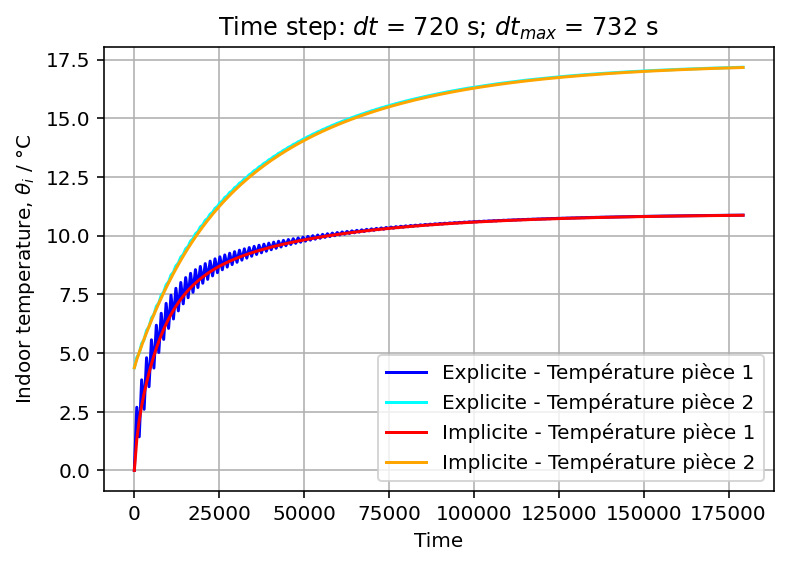
</p>

Nous pouvons observer que la température extérieure fluctue naturellement, tandis que la température intérieure suit ces variations avec un certain amortissement lié à l’inertie thermique du bâtiment. On observe également des pics de température intérieure, en réponse aux apports thermiques, probablement dus à l’ensoleillement ou à une sollicitation du système de chauffage. Le second sous-graphe montre la puissance thermique fournie par le système HVAC, ajustée en fonction des besoins, en complément des apports solaires.

### Simation avec des données météorologiques

L'irradiance solaire sur les murs dépend de l’angle entre le faisceau solaire et la surface ainsi que de l’angle normal à la surface, de l’azimut et de l’angle de pente.
Nous avons également besoin de l’albédo de la surface, que nous considérons égal à 0,2.

Le rayonnement solaire total est la quantité de rayonnement reçue sur une surface pendant un nombre de minutes précédant l’heure indiquée :

$$
E_e=E_{e,dir}+E_{e,diff}+E_{e,refl}
$$

- $E_{e,dir}$ : irradiance directe
- $E_{e,diff}$ : irradiance diffuse
- $E_{e,refl}$ : rayonnement solaire total reçu par réflexion depuis la surface en face du mur

Dans les données, nous avons pour chaque heure d’une période :

- la température de l’air ($°C$),
- le rayonnement solaire normal ($W·m⁻²$),
- et le rayonnement solaire diffus moyen reçu pendant 1 heure ($W·m⁻²$).

<p align="center">
    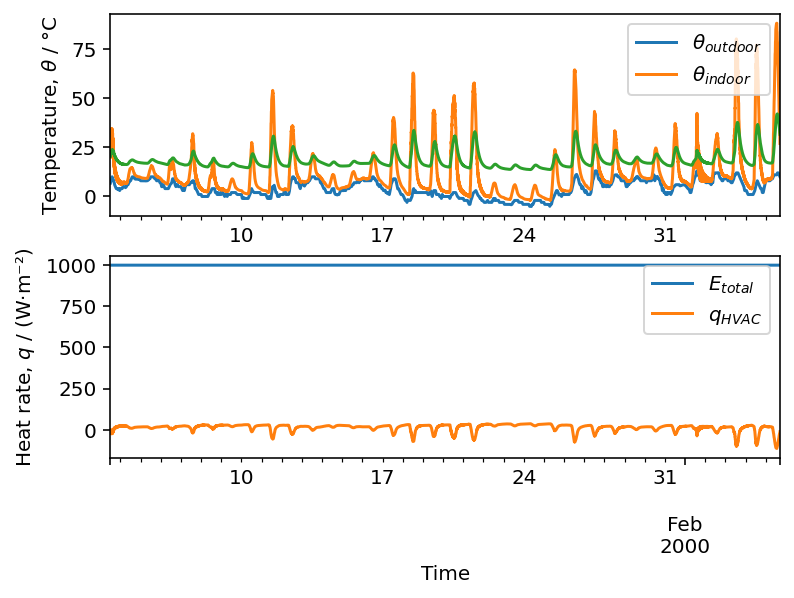
</p>

La température intérieure des deux pièces augmente progressivement jusqu’à atteindre un régime permanent. On observe que la méthode explicite produit des oscillations initiales plus marquées, caractéristiques d’une réponse plus rapide mais moins stable à court terme, alors que la méthode implicite génère une courbe plus stable. Les écarts entre les pièces reflètent les différences d’inertie thermique dûes aux différences géométrique. Tout cela nous permet de valider le bon fonctionnement des deux schémas d’intégration dans des conditions idéales.



In [ ]:

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 12 21:31:57 2023

@author: cghiaus

Thermal circuit and state-space representation for a thermal circuit
with capacities in some nodes: cubic building
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem


# Physical analysis
# =================
l = 5               # m length of the cubic room
Sg = l**2           # m² surface of the glass wall
Sc = Si = 5 * Sg    # m² surface of concrete & insulation of the 5 walls

# Thermo-physical properties
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)

wall = {'Conductivity': [1.4, 0.027, 1.4, 0.18],  # W/(m·K)
        'Density': [2300, 55, 2500, 85],        # kg/m³
        'Specific heat': [880, 1210, 750, 2380],  # J/(kg·K)
        'Width': [0.2, 0.08, 0.004, 0.05],
        'Surface': [5 * l**2, 5 * l**2, l**2, 1.935],  # m²
        'Slices': [2, 1, 1, 2]}                # number of  slices
wall1 = pd.DataFrame(wall, index=['Concrete', 'Insulation', 'Glass','Oak'])

concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 5 * l**2}

insulation = {'Conductivity': 0.027,
              'Density': 55.0,
              'Specific heat': 1210,
              'Width': 0.08,
              'Surface': 5 * l**2}

glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': l**2}

oak = {'Conductivity': 0.18,               # W/(m·K)
         'Density': 85,                   # kg/m³
         'Specific heat': 2380,             # J/(kg⋅K)
         'Width': 0.05,                     # m
         'Surface': 1.935}                   # m²

wall = pd.DataFrame.from_dict({'Layer_out': concrete,
                               'Layer_in': insulation,
                               'Glass': glass,
                               'Oak': oak},
                              orient='index')

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
ε_oLW = 0.90    # long wave emmisivity: oak
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass

σ = 5.67e-8     # W/(m²⋅K⁴) Stefan-Bolzmann constant

Fwg = 1 / 5     # view factor wall - glass

# convection coefficients
h = pd.DataFrame([{'in': 8., 'out': 25}], index=['h'])  # W/(m²⋅K)

# Thermal circuit
# ===============
# thermal conductances
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
G_door =oak['Conductivity'] / oak['Width'] * oak['Surface']

# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass
Go = h * wall['Surface'][3]    # door

# long wave radiation
Tm = 20 + 273   # K, mean temp for radiative exchange

GLW1 = 4 * σ * Tm**3 * ε_wLW / (1 - ε_wLW) * wall['Surface']['Layer_in']
GLW12 = 4 * σ * Tm**3 * Fwg * wall['Surface']['Layer_in']
GLW2 = 4 * σ * Tm**3 * ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass']
GLW3 = 4 * σ * Tm**3 * ε_oLW / (1 - ε_oLW) * wall['Surface']['Oak']

GLW = 1 / (1 / GLW1 + 1 / GLW12 + 1 / GLW2 + 1 / GLW3)

# ventilation & advection
Va = l**3                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration

Gv = air['Density'] * air['Specific heat'] * Va_dot

# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0
Kp = 0

# temperature nodes
nθ = 17      # number of temperature nodes
θ = [f'θ{i}' for i in range(17)]

# flow-rate branches
nq = 26     # number of flow branches
q = [f'q{i}' for i in range(26)]
# glass: convection outdoor & conduction

Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

# Thermal capacities
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va

# System of algebraic-differential equations (DAE)
# ================================================
A = np.zeros([26,17])       # n° of branches X n° of nodes
A[0, 0] = 1                 # branch 0: -> node 0
A[1, 0], A[1, 1] = -1, 1   # branch 1: node 0 -> node 1
A[5,0], A[5,4] = -1, 1
A[2,1],A[2,2]= -1, 1
A[3,2], A[3,3]= -1, 1
A[4,3],A[4,4]=-1, 1
A[6,4],A[7,4]=-1, -1
A[7,5]=1
A[6,6]=1
A[8,7]=1
A[9,7]=-1
A[9,5]=1
A[10,5]=-1
A[10,6]=1
A[11,6]=1
A[12,6]=1
A[13,6]=1
A[13,8]=-1
A[14,8]=1
A[14,9]=-1
A[15,9]=1
A[15,10]=-1
A[16,10]=1
A[16,11]=-1
A[17,11]=-1
A[17,6]=1
A[18,11]=1
A[19,11]=1
A[20,11]=1
A[20,12]=-1
A[21,12]=1
A[21,13]=-1
A[22,13]=1
A[22,14]=-1
A[23,14]=1
A[23,15]=-1
A[24,15]=1
A[24,16]=-1
A[25,16]=1

G = np.zeros((26,26))

G[0,0]=G[25,25] = Gw['out']
G[1,1] = G[2,2] = G[24,24] = G[23,23] = 2 * G_cd['Layer_out']
G[3,3] = G[4,4] = G[13,13] = G[14,14] = G[15,15] = G[16,16] = G[21,21] = G[22,22] = 2 * G_cd['Layer_in']
G[5,5] = G[17,17] = 2 * G_door
G[6,6] = G[20,20] = Gw['in']
G[7,7] = GLW
G[8,8] = Ggs
G[9,9] = 2 * G_cd['Glass']
G[10,10] = Gg['in']
G[11,11] = G[19,19] = Gv
G[12,12] = G[18,18] = Kp




# np.set_printoptions(precision=3, threshold=16, suppress=True)
# pd.set_option("display.precision", 1)
pd.DataFrame(G, index=q)

neglect_air_glass = False

b = np.zeros(26)        # branches
b[[0, 8, 11, 12,18,19,25]] = 1   # branches with temperature sources

f = np.zeros(17)         # nodes
f[[0, 4, 6, 7, 8, 10, 11,12,16]] = 1     # nodes with heat-flow sources

y = np.zeros(17)         # nodes
y[[6,11]] = 1              # nodes (temperatures) of interest

# State-space representation
# ==========================
# Créer la capacité thermique C comme une matrice (15x15)
neglect_air_glass = False

if neglect_air_glass:

    C_nodes = pd.Series(0.0, index=θ)
    C_nodes['θ1'] = C['Layer_out']
    C_nodes['θ3'] = C['Layer_in']

    C_nodes['θ9'] = C['Layer_in']
    C_nodes['θ13'] = C['Layer_in']
    C_nodes['θ15'] = C['Layer_out']
    C = C_nodes

else:

    C_nodes = pd.Series(0.0, index=θ)
    C_nodes['θ1'] = C['Layer_out']
    C_nodes['θ3'] = C['Layer_in']
    C_nodes['θ6'] = C['Air']
    C_nodes['θ7'] = C['Glass']
    C_nodes['θ9'] = C['Layer_in']
    C_nodes['θ13'] = C['Layer_in']
    C_nodes['θ15'] = C['Layer_out']
    C = C_nodes

# pd.set_option("display.precision", 3)
pd.DataFrame(C, index=θ)



y = np.zeros(17)
y[[6, 12]] = 1


A = pd.DataFrame(A, index=q, columns=θ)
G = pd.Series(np.diag(G), index=q)
C = pd.Series(C, index=θ)
b = pd.Series(b, index=q)
f = pd.Series(f, index=θ)
y = pd.Series(y, index=θ)

TC = {"A": A,
      "G": G,
      "C": C,
      "b": b,
      "f": f,
      "y": y}


[As, Bs, Cs, Ds, us] = dm4bem.tc2ss(TC)
print(Bs.shape)

# Steady-state
# ============
# from system of DAE
b = np.zeros(26)        # temperature sources
b[[0, 8, 11,19,25]] = 10      # outdoor temperature
b[[12]]=b[[18]] = 20            # indoor set-point temperature

f = np.zeros(17) # flow-rate sources
f[[6]]=f[[11]] = 1000
G_matrix = np.diag(G.values)  # transforme Series G en matrice diagonale
θ = np.linalg.inv(A.T @ G_matrix @ A.values) @ (A.T @ G_matrix @ b + f)

print(f'θ = {np.around(θ, 2)} °C')

# from state-space representation
bT = np.array([10, 10, 10,10,10,20,20])     # [To, To, To, Tisp]
fQ = np.array([0, 0, 0, 0,0,0,0,0,0])         # [Φo, Φi, Qa, Φa]
u = np.hstack([bT, fQ])
print(f'u = {u}')
yss = (-Cs.values @ np.linalg.inv(As.values) @ Bs + Ds.values) @ u

print(yss)
print(f'yss = {yss[0]:.2f},{yss[1]:.2f} °C')


# Dynamic simulation
# ==================
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / 3600:.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# Step response
# -------------
# Create input_data_set
# ---------------------
# time vector


# DateTimeIndex starting at "00:00:00" with a time step of dt




# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps

t = np.arange(0, n * dt, dt)        # time vector for n time steps
n = int(np.floor(duration / dt))    # number of time steps
print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
time = pd.date_range(start="2000-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")
To = 10 * np.ones(n)        # outdoor temperature
Ti_sp = 20 * np.ones(n)     # indoor temperature set point
Φa = 0 * np.ones(n)         # solar radiation absorbed by the glass
Qa = Φo = Φi = Φa           # auxiliary heat sources and solar radiation

data = {'To': To, 'Ti_sp': Ti_sp, 'Φo': Φo, 'Φi': Φi, 'Qa': Qa, 'Φa': Φa}
input_data_set = pd.DataFrame(data, index=time)
u = np.zeros([16, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0, :]=u[1, :]=u[2, :]=u[3, :] =u[4, :]= To    # To = 10 for n time steps
u[5, :]=u[6,:] = Ti_sp# Tisp = 20 for n time steps

n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u
fig, ax = plt.subplots()

# Tracer les courbes pour les deux pièces
ax.plot(t, y_exp.iloc[0], label='Explicite - Température pièce 1', color='blue')
ax.plot(t, y_exp.iloc[1], label='Explicite - Température pièce 2', color='cyan')

ax.plot(t, y_imp.iloc[0], label='Implicite - Température pièce 1', color='red')
ax.plot(t, y_imp.iloc[1], label='Implicite - Température pièce 2', color='orange')

# Ajouter les informations demandées
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: $dt$ = {dt:.0f} s; $dt_{{max}}$ = {dtmax:.0f} s')
ax.legend()
ax.grid(True)

plt.show()

y_exp_np = y_exp.values  # shape (n_outputs, n_timesteps)
last2 = y_exp_np[:, -2]

print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {float(θ[6]):.4f} °C')
print(f'- state-space model: {float(yss[0]):.4f} °C and {float(yss[1]):.4f}')
#print(f'- steady-state response to step input: {float(y_exp[:, -2]):.4f} °C')
print(f'- steady-state response to step input: {last2[0]:.4f} °C')

# Simulation with weather data
# ----------------------------
# Input vector
# weather data
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'

start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

filename = 'FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(
    weather.index >= start_date) & (
    weather.index < end_date)]

# solar radiatiion on the walls
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
rad_surf['Etot'] = rad_surf.sum(axis=1)

# resample the weather data
data = pd.concat([weather['temp_air'], rad_surf['Etot']], axis=1)
data = data.resample(str(dt) + 's').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

# other inputs
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

# input vector
To = data['To']
Ti = data['Ti']
Φo = α_wSW * wall['Surface']['Layer_out'] * data['Etot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Etot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Etot']

u = pd.concat([To, To, To,To,To,Ti, Ti, Φo, Φo, Φi,Φi,Φi,Φi,Qa,Qa, Φa], axis=1)
u.columns.values[[7, 8, 9,10,11,12,15]] = ['Φo','Φo', 'Φi', 'Φi', 'Φi', 'Φi', 'Φa']


# Initial conditions
θ0 = 20.0                   # °C, initial temperatures
θ = pd.DataFrame(index=u.index)
θ[As.columns] = θ0          # fill θ with initial valeus θ0

I = np.eye(As.shape[0])     # identity matrix
explicit_Euler=True
print(Bs.shape,(u.iloc[k]).shape)
if explicit_Euler:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = (I + dt * As) @ θ.iloc[k] + dt * Bs.values @ u.iloc[k].values
else:
    for k in range(u.shape[0] - 1):
        θ.iloc[k + 1] = np.linalg.inv(
            I - dt * As) @ (θ.iloc[k] + dt * Bs @ u.iloc[k].values)

# outputs

y = (Cs.values @ θ.T.values + Ds.values @ u.T.values).T

Kp = TC['G']['q11']     # controller gain
S = 25  # m², surface area of the toy house

q_HVAC = Kp * (u['Ti'].iloc[:, 0] - y[:,0]) / S  # W/m²

data = pd.DataFrame({'To': data['To'],
                     'θ1': y[:,0],
                     'θ2': y[:,1],
                     'Etot': 1000,
                     'q_HVAC': q_HVAC})

fig, axs = plt.subplots(2, 1)
data[['To', 'θ1','θ2']].plot(ax=axs[0],
                        xticks=[],
                        ylabel='Temperature, $θ$ / °C')

axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Etot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / (W·m⁻²)')
axs[1].set(xlabel='Time')
axs[1].legend(['$E_{total}$', '$q_{HVAC}$'],
              loc='upper right')
plt.show();